## Computer vision 2022 Assignment 3: Deep Learning for Perception Tasks

This assignment contains 2 questions. The first question probes understanding of deep learning for classification. The second question requires you to write a short description of a Computer Vision method. You wil need to submit two separate files, one for each question.

In [ ]:
import numpy as np # This is for mathematical operations

# this is used in plotting 
import matplotlib.pyplot as plt 
import time
import pylab as pl
from IPython import display

%matplotlib inline

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [ ]:
#### Tutorial Code
####PyTorch has two primitives to work with data: torch.utils.data.DataLoader and torch.utils.data.Dataset. 
#####Dataset stores samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset.
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

# Download training data from open datasets. 
##Every TorchVision Dataset includes two arguments: 
##transform and target_transform to modify the samples and labels respectively.

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

We pass the Dataset as an argument to DataLoader. This wraps an iterable over our dataset and supports automatic batching, sampling, shuffling, and multiprocess data loading. Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

In [ ]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


Add in a code cell to inspect the training data, as per Q1.1. Each element of the training_data structure has a greyscale image (which you can use plt.imshow(img[0,:,:]) to display, just like you did in previous assignments.  

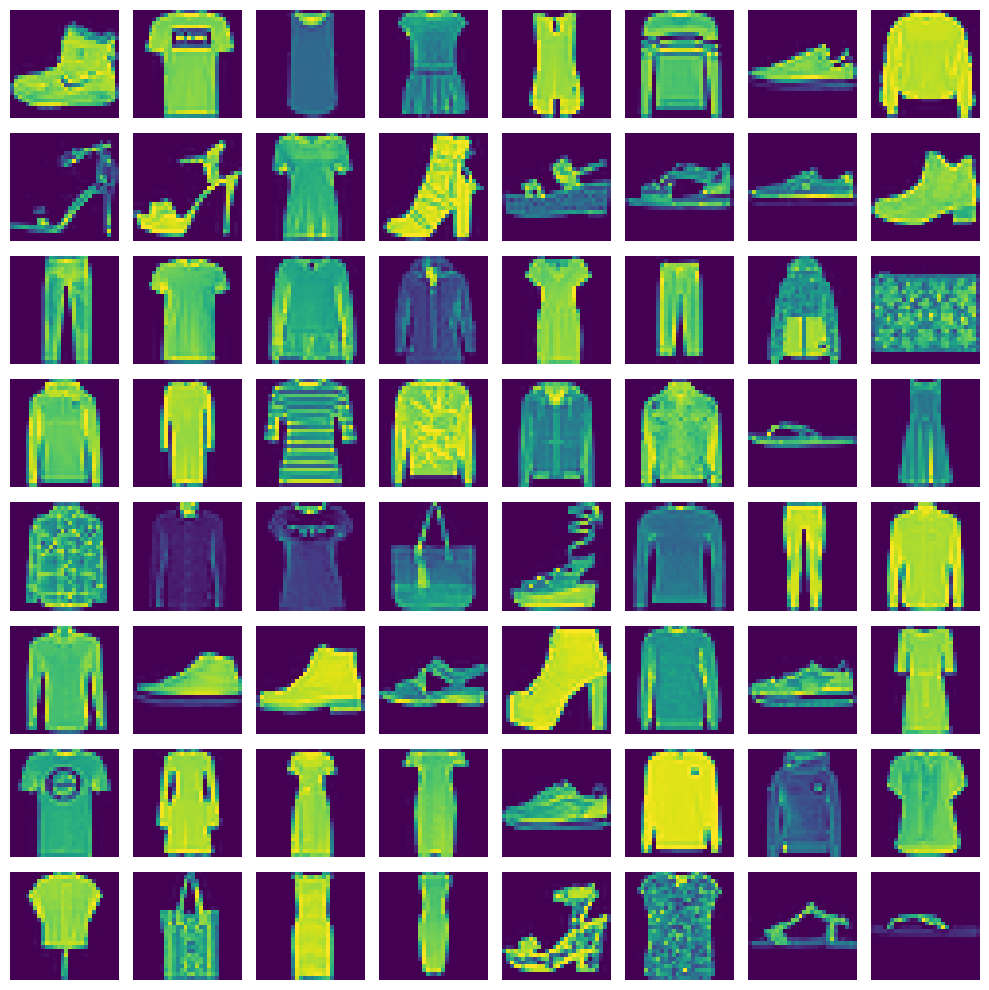

In [ ]:
fig, axes = plt.subplots(8, 8, figsize=(10, 10))
# Code cell for training image display
for images, labels in train_dataloader:
    for j,img in enumerate(images):
        ax = axes[j // 8, j % 8]
        ax.imshow(img[0,:,:])
        ax.axis('off')
    # stop after first batch
    break

plt.tight_layout()
plt.show()

To define a neural network in PyTorch, we create a class that inherits from nn.Module. We define the layers of the network in the init function and specify how data will pass through the network in the forward function. To accelerate operations in the neural network, we move it to the GPU if available.

### ReLu

ReLU activation function introduces non-linearity into the network. It applies the element-wise Rectified Linear Unit function, allowing the network to learn more complex patterns and representations.

In [ ]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

import torch.nn.functional as F

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
       )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)

        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [ ]:
###Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and backpropagates the prediction error to adjust the model’s parameters.

In [ ]:
def train(dataloader, model, loss_fn, optimizer, parallel_process=False):
    size = len(dataloader.dataset)
    model.train()
    if parallel_process:
        # Utilize multiple CPU cores
        model = nn.DataParallel(model)  
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
## Define a test function
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
#Train and test the model
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.311823  [    0/60000]
loss: 2.293911  [ 6400/60000]
loss: 2.265230  [12800/60000]
loss: 2.256480  [19200/60000]
loss: 2.250272  [25600/60000]
loss: 2.209446  [32000/60000]
loss: 2.228949  [38400/60000]
loss: 2.188281  [44800/60000]
loss: 2.194393  [51200/60000]
loss: 2.159296  [57600/60000]
Test Error: 
 Accuracy: 47.7%, Avg loss: 2.148966 

Epoch 2
-------------------------------
loss: 2.164748  [    0/60000]
loss: 2.152273  [ 6400/60000]
loss: 2.082622  [12800/60000]
loss: 2.106243  [19200/60000]
loss: 2.058549  [25600/60000]
loss: 1.984820  [32000/60000]
loss: 2.032808  [38400/60000]
loss: 1.940514  [44800/60000]
loss: 1.958351  [51200/60000]
loss: 1.891152  [57600/60000]
Test Error: 
 Accuracy: 57.9%, Avg loss: 1.878357 

Epoch 3
-------------------------------
loss: 1.909466  [    0/60000]
loss: 1.879674  [ 6400/60000]
loss: 1.751608  [12800/60000]
loss: 1.810586  [19200/60000]
loss: 1.695704  [25600/60000]
loss: 1.638910  [32000/600

# Question 1: A simple classifier, 20 marks (70%)

For this exercise, we provide demo code showing how to train a network on a small dataset called Fashion-MNIST. Please run through the code "tutorial-style" to get a sense of what it is doing. Then use the code alongside lecture notes and other resources to understand how to use pytorch libraries to implement, train and use a neural network.

For the Fashion-MNIST dataset the lables from 0-9 correspond to various clothing classes so you might find it convenient to create a python list as follows:

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

You will need to answer various questions about the system, how it operates, the results of experiments with it and make modifications to it yourself. You can change the training scheme and the network structure. 

Organize your own text and code cell to show the answer of each questions.

Detailed requirements:

Q1.1 (1 point)

Extract 3 images of different types of clothing from the training dataset, print out the size/shape of the training images, and display the three with their corresponding labels. 

image label: Ankle boot, image size: torch.Size([1, 28, 28])


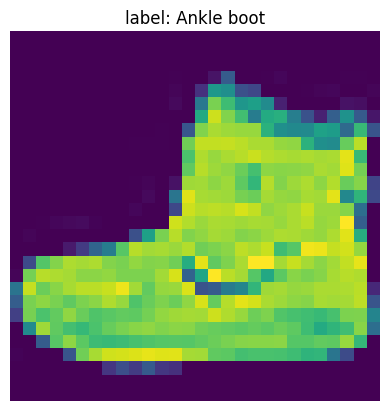

image label: T-shirt/top, image size: torch.Size([1, 28, 28])


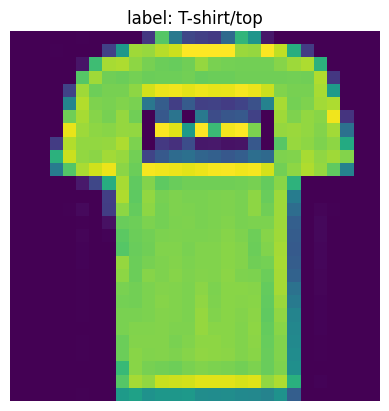

image label: Dress, image size: torch.Size([1, 28, 28])


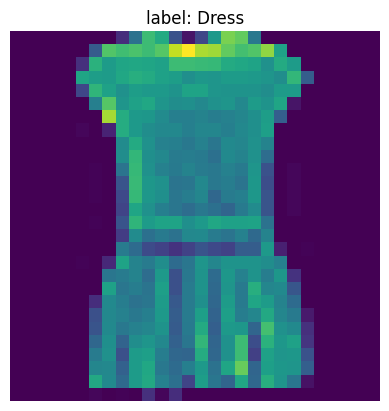

In [ ]:
fashion_mnist_classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

selected_images = []
selected_labels = []

for i, (image, label) in enumerate(training_data):
    if label not in selected_labels:
        selected_images.append(image)
        selected_labels.append(label)
    
    if len(selected_images) == 3:
        break

#print(fashion_mnist_classes[label], label)

# display image stats
for i, image in enumerate(selected_images):
    label_number = selected_labels[i]
    
    print(f'image label: {fashion_mnist_classes[label_number]}, image size: {image.size()}')
    plt.title(f'label: {fashion_mnist_classes[label_number]}')
    # image.squeeze() or image[0,:,:] removes signle dimension: dim((1,28,28)) => dim(28, 28)
    plt.axis('off')
    plt.imshow(image[0,:,:])
    plt.show()



Q1.2 (2 point) Run the training code for 10 epochs, for different values of the learning rate. Fill in the table below and plot the loss curves for each experiment:

Table 1:

|Lr|Accuracy|
|---|---|
|1   |      0.1|
|0.1|        0.8747  |
|0.01|    0.8332     |
|0.001  |    0.7097    |
	

In [ ]:
"""
creating an evaluation function based on train and test function. 
This function does calcaultes loss and accuracy of given dataloader and does not update models parameters or perform backpropagation
"""
def evaluate(dataloader, model, loss_fn, accuracy=False):
    model.eval()
    loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss += loss_fn(outputs, labels).item()

            if accuracy:
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

    model.train()

    loss_ = loss / len(dataloader)
    accuracy = 0 if total == 0 else correct / total
    if accuracy:
        return loss_, accuracy 
    else:
        return loss_

In [ ]:
import math
table = []
learning_rates = [0.001, 0.01, 0.1, 1] 
loss_fn = nn.CrossEntropyLoss()

for learning_rate in learning_rates:
    model =  NeuralNetwork().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    epochs = 10
    train_losses = []
    test_losses = []
    test_accuracies = []

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_dataloader, model, loss_fn, optimizer)
        train_loss = evaluate(train_dataloader, model, loss_fn)
        train_losses.append(train_loss)

        test_loss,test_accuracy = evaluate(test_dataloader, model, loss_fn, accuracy=True)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Test Loss: {test_loss:.4f}")
        if (math.isnan(train_loss) or math.isnan(test_loss)): break

    table.append([learning_rate, train_losses, test_losses, test_accuracies])

print("Done!")

Epoch 1
-------------------------------
loss: 2.303259  [    0/60000]
loss: 2.289183  [ 6400/60000]
loss: 2.259434  [12800/60000]
loss: 2.256963  [19200/60000]
loss: 2.248709  [25600/60000]
loss: 2.211771  [32000/60000]
loss: 2.228213  [38400/60000]
loss: 2.182537  [44800/60000]
loss: 2.176861  [51200/60000]
loss: 2.158000  [57600/60000]
Train Loss: 2.1428
Test Loss: 2.1443
Epoch 2
-------------------------------
loss: 2.152659  [    0/60000]
loss: 2.142408  [ 6400/60000]
loss: 2.073908  [12800/60000]
loss: 2.091441  [19200/60000]
loss: 2.044779  [25600/60000]
loss: 1.983531  [32000/60000]
loss: 2.009546  [38400/60000]
loss: 1.918738  [44800/60000]
loss: 1.916486  [51200/60000]
loss: 1.855395  [57600/60000]
Train Loss: 1.8464
Test Loss: 1.8497
Epoch 3
-------------------------------
loss: 1.883703  [    0/60000]
loss: 1.854466  [ 6400/60000]
loss: 1.725296  [12800/60000]
loss: 1.767411  [19200/60000]
loss: 1.669717  [25600/60000]
loss: 1.627083  [32000/60000]
loss: 1.642377  [38400/600

In [ ]:
print("Learning Rate\t  Train Losses\tTest Losses\tTest Accuracies")
for row in table:
    learning_rate, train_losses, test_losses, test_accuracies = row
    print(f"{learning_rate}\t\t{train_losses[-1]}\t{test_losses[-1]}\t{test_accuracies[-1]}")

Learning Rate	  Train Losses	Test Losses	Test Accuracies
0.001		0.775729897116293	0.7916442207090414	0.7097
0.01		0.42443494748141464	0.46380174264406704	0.8332
0.1		0.26150183755356365	0.34969592421867285	0.8747
1		2.305853618741798	2.3058451087611496	0.1


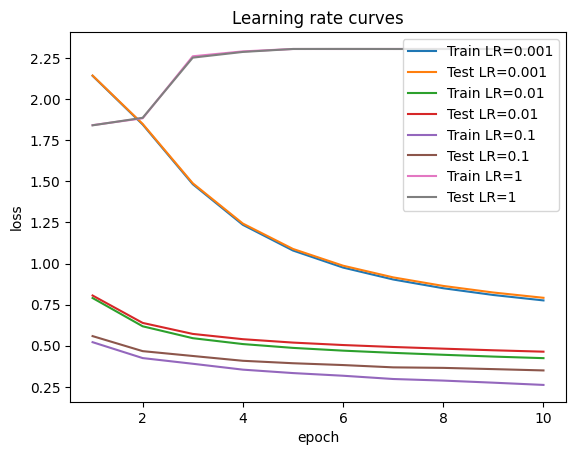

In [ ]:
# loss curve plot
for row in table:
    learning_rate, train_losses, test_losses, _ = row
    plt.plot(range(1, epochs + 1), train_losses, label=f"Train LR={learning_rate}")
    plt.plot(range(1, epochs + 1), test_losses, label=f"Test LR={learning_rate}")

plt.title('Learning rate curves')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()


Q1.3 (3 point)  (3 point) Report the number of epochs when the network converges (or nukber of epochs for the best accuracy, if it fails to converge). Fill in the table below and plot the loss curve for each experiment:

Given the default training deafult training structure defined in the example above with 3 linear layers and ReLu activations functions
  the accuracy did not reach 90% but came close. 

Table 2a (training until accuracy converges on example neural network provided)
 
|Lr|Accuracy|Epoch|
|---|---|---|
|1		    |0.1000|		8|
|0.1		|0.8804|		15|
|0.01		|0.8524|		18|
|0.001		|0.8112|		33|


Below I used defined a convolutional neural network called FahsionNet which performs far better than the default network provided. It was inspired by this article: https://towardsdatascience.com/build-a-fashion-mnist-cnn-pytorch-style-efb297e22582

In this network the architecture consists of two convolutional layers (conv1 and conv2) followed by a ReLU activation function (relu1 and relu2) and max pooling operation (maxpool1 and maxpool2)
The output from the convolutional layers is flattened and fed into two fully connected layers (fc1 and fc2), with a ReLU activation applied after the first fully connected layer and the final layer has 10 output units, corresponding to the 10 classes in the FashionMNIST dataset.

Table 2:

|Lr|Accuracy|Epoch|
|---|---|---|
|1  |0.1|2|
|0.1|0.9035|8|
|0.01|0.9005|31|
|0.001|0.9001|42|

In [ ]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

import torch.nn.functional as F

# Define improved neural network model inspired from (FashionNet): https://arxiv.org/pdf/1810.02443.pdf
class FashionNet(nn.Module):
    def __init__(self):
        super(FashionNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(7 * 7 * 64, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu3(out)
        out = self.fc2(out)
        return out

model = FashionNet().to(device)
print(model)

Using cpu device
FashionNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
# store results in a table
table = []
# learning_rates = [0.001, 0.01, 0.1, 1] 
learning_rates = [1,0.01,0.001]
loss_fn = nn.CrossEntropyLoss()
convergence_threshold = 0.0001  

for learning_rate in learning_rates:
    model = FashionNet().to(device)
    # model =  NeuralNetwork().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    epochs = 0
    previous_accuracy = 0
    accuracy = 0
    
    while accuracy < 0.9:
        epochs += 1
        print(f"Epoch {epochs}\n-------------------------------")
        train(train_dataloader, model, loss_fn, optimizer,parallel_process=True)
        _, accuracy = evaluate(test_dataloader, model, loss_fn, accuracy=True)
        print(f"Accuracy: {accuracy:.4f}")
        # set a stop condition
        if abs(accuracy - previous_accuracy) < convergence_threshold or epochs > 100:
            print(f"Accuracy converged. Stopping training after {epochs} epochs with accuracy of {accuracy}.")
            break
        
        previous_accuracy = accuracy

    table.append([learning_rate, accuracy, epochs])
    

print("Done!")

Epoch 1
-------------------------------
loss: 2.316884  [    0/60000]
loss: 2.228531  [ 6400/60000]
loss: 2.313527  [12800/60000]
loss: 2.305349  [19200/60000]
loss: 2.281542  [25600/60000]
loss: 2.304950  [32000/60000]
loss: 2.305945  [38400/60000]
loss: 2.288610  [44800/60000]
loss: 2.300421  [51200/60000]
loss: 2.330204  [57600/60000]
Accuracy: 0.1000
Epoch 2
-------------------------------
loss: 2.313046  [    0/60000]
loss: 2.306795  [ 6400/60000]
loss: 2.312776  [12800/60000]
loss: 2.304621  [19200/60000]
loss: 2.281377  [25600/60000]
loss: 2.304950  [32000/60000]
loss: 2.305945  [38400/60000]
loss: 2.288610  [44800/60000]
loss: 2.300421  [51200/60000]
loss: 2.330204  [57600/60000]
Accuracy: 0.1000
Accuracy converged. Stopping training after 2 epochs with accuracy of 0.1.
Epoch 1
-------------------------------
loss: 2.311132  [    0/60000]
loss: 2.160923  [ 6400/60000]
loss: 1.299356  [12800/60000]
loss: 1.016665  [19200/60000]
loss: 0.842874  [25600/60000]
loss: 0.834858  [3200

**Q1.4 (2 points) Compare the results in table 1 and table 2, what is your observation and your understanding of learning rate?**

My observation from comparing Table 1 and Table 2 is that higher learning rate values result in faster convergence, requiring fewer epochs for training. However, if the learning rate is too high, it can lead to poor accuracy. For instance, in Table 2, a learning rate of 1 converges too quickly and overshoots the minimum, resulting in a poor accuracy of 0.1 and the loss function diverges and misses the optimal solution.

On the other hand, a learning rate that is too low can slow down the convergence process, necessitating more epochs to reach an acceptable solution. For example, in Table 2, a learning rate of 0.001 requires 42 epochs to achieve an accuracy of at least 90%, wihlw a learning rate of 0.1 only requires 8 epochs to reach the same level of accuracy.

This trend is alsow demonstrated in table 1 where sufficiently high learning rates converge to an optimal solution faster. For example, a learning rate of 0.1 yields an accuracy of 0.87 after only just 10 epoch suggeting that picking the right learning rate makes training faster and more efficient.

As a result choosing a high enough learning rate without overshotting the optimal solution can lead to more efficient and accurate training. From the results of both tables, a learning rate of approximately 0.1 appears to be a good choice.


Q1.5 (5 points) Build a wider network by modifying the code that constructs the network so that the hidden layer(s) contain more perceptrons, and record the accuracy along with the number of trainable parameters in your model.  Now modify the original network to be deeper instead of wider (i.e. by adding more hidden layers). Record your accuracy and network size findings. Plot the loss curve for each experiment. Write down your conclusions about changing the network structure?  

Table 3: trained with 15 epochs and lr = 0.1 based on best accuracy parameters from 1.3

|Structures	|Accuracy|	Number of Parameters|
|---|---|---|
|Base|0.8862|669706|
|Wider|0.8785|1863690|
|Deeper|0.8728|932362|

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

def getTrainableParameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def plotLossCurve(train_losses, test_losses, label=""):
    epochs = len(train_losses)
    plt.plot(range(1, epochs + 1), train_losses, label='Train {label}')
    plt.plot(range(1, epochs + 1), test_losses, label='Test {label}')
    plt.title(f'Learning rate curves for {label} network')
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

def trainModel(modelObj, best_lr = 0.1, epochs = 15):
    
    """ learning rate scheduler for adaptive learning rate; adjust the learning rate every 5 epochs, reducing it by a factor of 0.1
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)   """
    cur_model =  modelObj.to(device)
    optimizer = torch.optim.SGD(cur_model.parameters(), lr=best_lr)
    loss_fn = nn.CrossEntropyLoss()

    train_losses = []
    test_losses = []
    test_accuracies = []

    for e in range(epochs):
        print(f"Epoch {e+1}\n-------------------------------")
        train(train_dataloader, cur_model, loss_fn, optimizer)

        train_loss = evaluate(train_dataloader, cur_model, loss_fn)
        train_losses.append(train_loss)

        test_loss,test_accuracy = evaluate(test_dataloader, cur_model, loss_fn, accuracy=True)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        print('accuracy: ', test_accuracy)

    print("Done!")
    
    return train_losses, test_losses, test_accuracies




In [ ]:
# train base model
baseModel = NeuralNetwork()
base_model_trainable_params =getTrainableParameters(baseModel)
base_model_train_losses, base_model_test_losses, base_model_test_accuracies = trainModel(baseModel)

Epoch 1
-------------------------------
loss: 2.302080  [    0/60000]
loss: 0.903078  [ 6400/60000]
loss: 0.593271  [12800/60000]
loss: 0.702498  [19200/60000]
loss: 0.596654  [25600/60000]
loss: 0.526781  [32000/60000]
loss: 0.546362  [38400/60000]
loss: 0.595043  [44800/60000]
loss: 0.612115  [51200/60000]
loss: 0.442166  [57600/60000]
accuracy:  0.7916
Epoch 2
-------------------------------
loss: 0.430798  [    0/60000]
loss: 0.439234  [ 6400/60000]
loss: 0.373934  [12800/60000]
loss: 0.436821  [19200/60000]
loss: 0.406055  [25600/60000]
loss: 0.453145  [32000/60000]
loss: 0.408563  [38400/60000]
loss: 0.497215  [44800/60000]
loss: 0.515853  [51200/60000]
loss: 0.413312  [57600/60000]
accuracy:  0.8194
Epoch 3
-------------------------------
loss: 0.338988  [    0/60000]
loss: 0.363492  [ 6400/60000]
loss: 0.311922  [12800/60000]
loss: 0.359859  [19200/60000]
loss: 0.337793  [25600/60000]
loss: 0.422979  [32000/60000]
loss: 0.354328  [38400/60000]
loss: 0.456617  [44800/60000]
loss

In [ ]:
class WiderNeuralNetwork(nn.Module):
    def __init__(self):
        super(WiderNeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.hiddenLayerWidth = 1024
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, self.hiddenLayerWidth),
            nn.ReLU(),
            nn.Linear(self.hiddenLayerWidth, self.hiddenLayerWidth),
            nn.ReLU(),
            nn.Linear(self.hiddenLayerWidth, 10)
       )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)

        return logits

# wide_model = WiderNeuralNetwork().to(device)
# print(wide_model)

In [ ]:
widerModel = WiderNeuralNetwork()
wider_model_trainable_params = getTrainableParameters(widerModel)
wider_model_train_losses, wider_model_test_losses, wider_model_test_accuracies = trainModel(widerModel)

Epoch 1
-------------------------------
loss: 2.314375  [    0/60000]
loss: 0.868639  [ 6400/60000]
loss: 0.560630  [12800/60000]
loss: 0.693698  [19200/60000]
loss: 0.638382  [25600/60000]
loss: 0.499916  [32000/60000]
loss: 0.537047  [38400/60000]
loss: 0.588095  [44800/60000]
loss: 0.613218  [51200/60000]
loss: 0.453290  [57600/60000]
accuracy:  0.797
Epoch 2
-------------------------------
loss: 0.418869  [    0/60000]
loss: 0.422804  [ 6400/60000]
loss: 0.371054  [12800/60000]
loss: 0.437777  [19200/60000]
loss: 0.402126  [25600/60000]
loss: 0.437593  [32000/60000]
loss: 0.405574  [38400/60000]
loss: 0.492528  [44800/60000]
loss: 0.509697  [51200/60000]
loss: 0.428032  [57600/60000]
accuracy:  0.8254
Epoch 3
-------------------------------
loss: 0.330149  [    0/60000]
loss: 0.352633  [ 6400/60000]
loss: 0.303800  [12800/60000]
loss: 0.361053  [19200/60000]
loss: 0.333558  [25600/60000]
loss: 0.406211  [32000/60000]
loss: 0.357864  [38400/60000]
loss: 0.436671  [44800/60000]
loss:

In [ ]:
class DeeperNeuralNetwork(nn.Module):
    def __init__(self):
        super(DeeperNeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            
            # add two additional hidden layers
            nn.Linear(512, 512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.ReLU(),

            nn.Linear(512, 10)
       )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)

        return logits

# deep_model = DeeperNeuralNetwork().to(device)
# print(deep_model)

In [ ]:
deeperModel = DeeperNeuralNetwork()
deeper_model_train_losses, deeper_model_test_losses, deeper_model_test_accuracies = trainModel(deeperModel)
deeper_model_trainable_params = getTrainableParameters(deeperModel)

Epoch 1
-------------------------------
loss: 2.305580  [    0/60000]
loss: 1.050304  [ 6400/60000]
loss: 0.664144  [12800/60000]
loss: 0.746815  [19200/60000]
loss: 0.576056  [25600/60000]
loss: 0.495623  [32000/60000]
loss: 0.512452  [38400/60000]
loss: 0.592334  [44800/60000]
loss: 0.599407  [51200/60000]
loss: 0.493800  [57600/60000]
accuracy:  0.7984
Epoch 2
-------------------------------
loss: 0.436280  [    0/60000]
loss: 0.440458  [ 6400/60000]
loss: 0.422296  [12800/60000]
loss: 0.436303  [19200/60000]
loss: 0.426728  [25600/60000]
loss: 0.468490  [32000/60000]
loss: 0.405490  [38400/60000]
loss: 0.515356  [44800/60000]
loss: 0.500081  [51200/60000]
loss: 0.457580  [57600/60000]
accuracy:  0.8269
Epoch 3
-------------------------------
loss: 0.331086  [    0/60000]
loss: 0.341964  [ 6400/60000]
loss: 0.338427  [12800/60000]
loss: 0.340931  [19200/60000]
loss: 0.351951  [25600/60000]
loss: 0.437215  [32000/60000]
loss: 0.352285  [38400/60000]
loss: 0.465960  [44800/60000]
loss

In [ ]:
# display table
print("Structures\tAccuracy\tParameters")
print(f"Base\t\t{base_model_test_accuracies[-1]}\t\t{base_model_trainable_params}")
print(f"Wider\t\t{wider_model_test_accuracies[-1]}\t\t{wider_model_trainable_params}")
print(f"Deeper\t\t{deeper_model_test_accuracies[-1]}\t\t{deeper_model_trainable_params}")

Structures	Accuracy	Parameters
Base		0.8862		669706
Wider		0.8785		1863690
Deeper		0.8728		932362


plotting loss curves


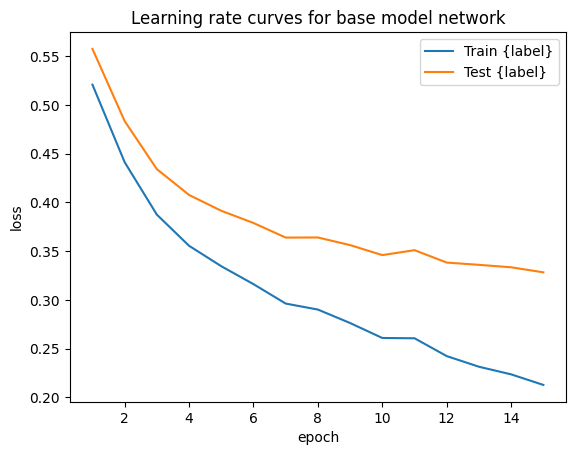

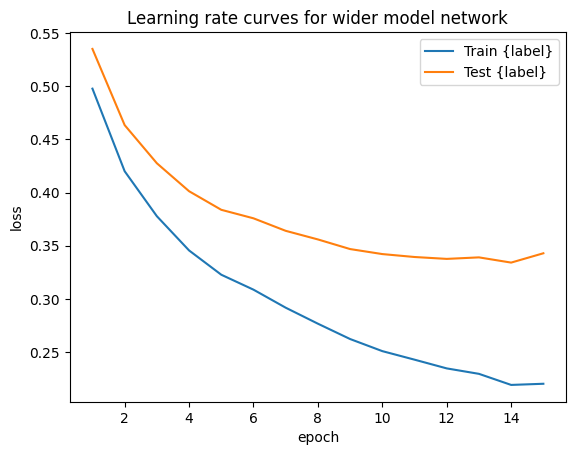

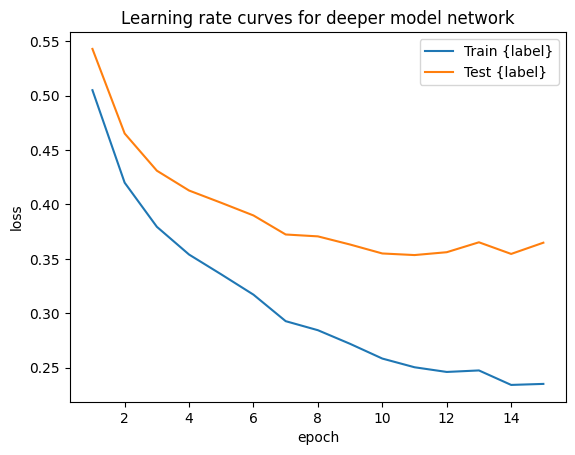

In [ ]:
print('plotting loss curves')
plotLossCurve(base_model_train_losses, base_model_test_losses, label="base model")
plotLossCurve(wider_model_train_losses, wider_model_test_losses, label="wider model")
plotLossCurve(deeper_model_train_losses, deeper_model_test_losses, label="deeper model")

### Write down your conclusions about changing the network structure?  

The models widerNeuralNetwork, DeeperNeuralNetwork, and NeuralNetwork (Base) were trained with 15 epochs and a learning rate of 0.1, which was found to be the optimal parameter combination for maximizing accuracy in the base neural network (as mentioned in 1.3). These parameters remain consistent across models for the sake of comparison, despite the possibility of achieving higher accuracy by altering them in different network structures.

The base neural network achieved the highest accuracy (0.8862) among the models. This model served as the benchmark for comparison throughout the experimentation.

The wider neural network, where the hiddenLayerWidth parameter was doubled from 512 to 1024, resulted in slightly lower accuracy (0.8785) compared to the base model. However, the wider network demonstrated increased model capacity due to a larger number of trainable parameters (1863690 compared to 669706 in the base model). It is important to note that wider networks may require more computational resources for training and inference. Thus, there is a tradeoff between accuracy and computational demands.

The deeper neural network, with two additional hidden layers, did not lead to improved accuracy (0.8728) compared to the base model accuracy (0.8862). This lack of improvement may be attributed to the MNIST fashion dataset not containing many complex and abstract features. Deeper networks typically excel at capturing such features, but in this case, the dataset did not provide ample opportunities for improvement. Deeper networks also tend to have a larger number of trainable parameters (932362 compared to 669706 in the base model), increasing the need for a larger training dataset to prevent overfitting.

Ultimately, the base neural network achieved the best accuracy, while the wider neural network demonstrated increased model capacity at the cost of higher computational requirements. The deeper neural network did not provide significant improvements, possibly due to the dataset's characteristics. These observations suggest that neither a wider or deeper network is more appropriate than the base neural network


Q1.6 (2 points) Calculate the mean of the gradients of the loss to all trainable parameters. Plot the gradients curve for the first 100 training steps. What are your observations? Note that this gradients will be saved with the training weight automatically after you call loss.backwards(). Hint: the mean of the gradients decrease.

In [ ]:
model = NeuralNetwork()
# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
# use best learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

mean_gradients = []
training_steps = []

for step, (X, y) in enumerate(train_dataloader):
    inputs, targets = X.to(device), y.to(device)
    # Forward pass
    outputs = model(inputs)
    # Calculate loss
    loss = loss_fn(outputs, targets)
    # Clear gradients
    optimizer.zero_grad()
    # Backward pass
    loss.backward()
    # Update model parameters
    optimizer.step()
    
    trainable_params = [param for param in model.parameters() if param.requires_grad]
    gradients = torch.cat([param.grad.flatten() for param in trainable_params])
    mean_gradient = gradients.mean()
    mean_gradients.append(mean_gradient.item())
    training_steps.append(step)
    print(f"Step: {step} Mean Gradient: {mean_gradient.item()}")
    if step == 100: break



Step: 0 Mean Gradient: -2.712404011617764e-06
Step: 1 Mean Gradient: 7.439743058057502e-06
Step: 2 Mean Gradient: -1.3969308383821044e-05
Step: 3 Mean Gradient: -4.112833630642854e-05
Step: 4 Mean Gradient: -5.443311601993628e-05
Step: 5 Mean Gradient: -4.230261765769683e-05
Step: 6 Mean Gradient: -7.152772741392255e-05
Step: 7 Mean Gradient: -8.936001540860161e-05
Step: 8 Mean Gradient: -7.800431922078133e-05
Step: 9 Mean Gradient: -0.00011950206680921838
Step: 10 Mean Gradient: -0.00011055904906243086
Step: 11 Mean Gradient: -0.00013236614177003503
Step: 12 Mean Gradient: -0.00010366810602135956
Step: 13 Mean Gradient: -0.0001426996459485963
Step: 14 Mean Gradient: -0.00010293463856214657
Step: 15 Mean Gradient: -0.00015456134860869497
Step: 16 Mean Gradient: -0.00017183832824230194
Step: 17 Mean Gradient: -0.00017919557285495102
Step: 18 Mean Gradient: -0.00017915840726345778
Step: 19 Mean Gradient: -0.000195639455341734
Step: 20 Mean Gradient: -0.00012541920295916498
Step: 21 Mean 

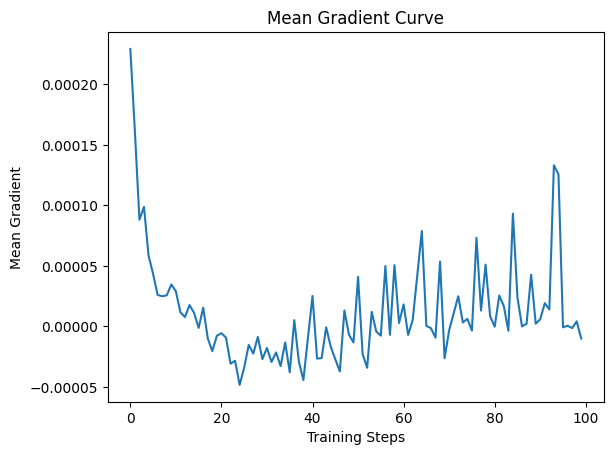

In [ ]:
mean_gradients = torch.tensor(mean_gradients).numpy()
training_steps = torch.tensor(training_steps).numpy()

# Plot the gradient curve
plt.plot(training_steps, mean_gradients)
plt.xlabel('Training Steps')
plt.ylabel('Mean Gradient')
plt.title('Mean Gradient Curve')
plt.show()

Q1.7 (5 points) Modify the network structure and training/test to use a small convolutional neural network instead of an MLP. Discuss your findings with regard to convergence, accuracy and number of parameters, relative to MLPs.  

Hint: Look at the structure of the CNN in the Workshop 3 examples.

In [ ]:
class ConvNeuralNet(nn.Module):
    def __init__(self):
        super(ConvNeuralNet, self).__init__()

        self.conv1 = nn.Conv2d(1, 6, 5) # input channel: 1
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)

        """ 
        with 28x28 and 2 pooling layers, the dimension of the image is reduced to 4x4:
        output_size = ((input_size - kernel_size) / stride) + 1 = ((28 - 5) / 1) + 1 = 24x24
        output_size = input_size / pool_size = 24 / 2 = 12
        second conv layer: ((12 - 5) / 1) + 1 = 8x8
        second pooling layer: 8/2 = 4 x 4 
        """
        
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # flatten the tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def train_cnn_model(model, trainloader, epochs=10, convergence_threshold=1e-4):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    current_accuracy = 0
    prev_accuracy = 0
    for epoch in range(epochs):
        running_loss = 0
        running_accuracy = 0
        for i, data in enumerate(trainloader):
            inputs, labels = data
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_accuracy += accuracy(outputs, labels)
        
        print(f'running_accuracy {running_accuracy:.3f} running_loss {running_loss:.3f}')
        current_accuracy = running_accuracy / len(trainloader)
        print(f'Epoch {epoch + 1} accuracy: {current_accuracy:.3f} loss: {running_loss:.3f}')

        if abs(current_accuracy - prev_accuracy) < convergence_threshold:
            print(f'breaking model due to convergence after {epoch} epochs')
            break

        prev_accuracy = current_accuracy

    print('Finished Training')
    return current_accuracy


def test_cnn_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'tested accuracy {(100 * correct / total)}')


In [ ]:
cnn_model  = ConvNeuralNet().to(device)
train_accuracy = train_cnn_model(cnn_model,train_dataloader, epochs=15, )

running_accuracy 183.016 running_loss 2030.429
Epoch 1 accuracy: 0.195 loss: 2030.429
running_accuracy 613.281 running_loss 840.099
Epoch 2 accuracy: 0.654 loss: 840.099
running_accuracy 676.734 running_loss 681.561
Epoch 3 accuracy: 0.721 loss: 681.561
running_accuracy 706.828 running_loss 611.144
Epoch 4 accuracy: 0.754 loss: 611.144
running_accuracy 727.266 running_loss 561.447
Epoch 5 accuracy: 0.775 loss: 561.447
running_accuracy 743.844 running_loss 523.601
Epoch 6 accuracy: 0.793 loss: 523.601
running_accuracy 756.078 running_loss 494.744
Epoch 7 accuracy: 0.806 loss: 494.744
running_accuracy 765.484 running_loss 472.039
Epoch 8 accuracy: 0.816 loss: 472.039
running_accuracy 772.641 running_loss 453.623
Epoch 9 accuracy: 0.824 loss: 453.623
running_accuracy 779.312 running_loss 437.365
Epoch 10 accuracy: 0.831 loss: 437.365
running_accuracy 784.188 running_loss 423.324
Epoch 11 accuracy: 0.836 loss: 423.324
running_accuracy 788.969 running_loss 409.998
Epoch 12 accuracy: 0.841 l

In [ ]:
print('number of trainable paramaters in CNN model : ', getTrainableParameters(cnn_model))
print(f'train accuracy', train_accuracy)

number of trainable paramaters in CNN model :  44426
train accuracy tensor(0.8537)


In [ ]:
test_cnn_model(cnn_model, test_dataloader)

tested accuracy 84.19


Discuss your findings with regard to convergence, accuracy and number of parameters, relative to MLPs.

Outcome for MLP network

|Lr|Accuracy|Epoch needed to converge|
|---|---|---|
|0.001		|0.8112|		33|

Outcome for CNN

|Lr|Accuracy|Epoch needed to converge|
|---|---|---|
|0.001		    |0.854|	15|

In the convolutional neural network I used the same structure fo the CNN in workshop 3 with two convolutional layers with ReLU activations, followed by max pooling layers to reduce spatial dimensions. After the convolutional layers, the output is flattened and passed through fully connected layers similar to the MLP structure.

The MLP network base model network had 669706 trainable parameters while the CNN had significantly fewer trainable parameters (44426). Generally, CNNs have fewer parameters than MLPs when applied to image data. This is because in a MLP structure, every pixel of the image is connected to every neuron in the first hidden layer, leading to a large number of connections and parameterswhile CNNs exploit the shared weights of convolutional filters, so have fewer trainable parameters which leads to more efficient learning of spatial features.

For the CNN I used a stochastic graident descent optimizer as used in workshop 3. (optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)) and achieved an testing accuracy of 84%. With this same laerning rate the MLP acheived a slighlty lower accuracy of 81%. 


Lastly,  the CNN was seen to converge faster in roughly half the amount of epochs than the MLP.  CNNs tend to converge faster and perform better on image data is due to their ability to capture local spatial patterns and hierarchical nature of convolutional layers enables them to learn hierarchical features in the data. Given the simplicity of images in the Fashion MNIST, the dataset may not properly demonstrate these improvements with CNNs compared to MLPs.

As a result, using a small CNN led to better convergence, improved accuracy for the given learning rate and a reduction in the number of parameters, suggesting that this model is more efficient and effective for this particular image classification task.

# Question 2: Proposal for Practical Applications (30%)

In this part of the assignment you need to write a report about an application of a computer vision algorithnm or technique. This can either be an application that you are aware of and possibly even use, such as a phone app, or it could be speculation -- an application that you think would benefit from using computer vision. 

Begin by choosing a particular CV idea, method or problem area, such as:

a. removing noise in an image

b. increasing the resolution of an image

c. detecting and/or identifying objects in an image

d. segmenting images into constituents parts

e. estimating the depth of an object from one or more images

f. estimating the motion of two objects in different frames

g. others

Now think about various ways your chosen technique could be used. Here is a list of possible applications you could consider, but you are not restricted to this list, and there will be credit given for sensible invention outside this list (but no penalty if you don't want to be "inventive"): image editing systems in your phone; enhancement of images from old film; obstacle detection and avoidance for a domestic robot; facial recognition for phone security; cancer detection; person tracking and re-identification in security cameras; sport decision review systems; road-sign detection and interpretation for self-driving cars.

This is a little bit back-to-front from what might happen in real life in which the application usually motivates the solution, but the emphasis here is on an understanding of the CV technique.

You need to write a short report (800 words max) in which you do the following:
1. Clearly define the CV problem/area and describe its application scenarios
2. Briefly describe a solution based on image processing, computer vision and/or machine learning.
3. Discuss the advantages and the limitations of this method in various application scenarios

Hint1: Submit an individual pdf report for question 2.

Hint2: Organise your report well

Hint3: You can use diagrams, flow charts or other figures in your report for better understanding of your solution.  

***You do not need to implement your solution; just write the proposal/report and submit it as a separate PDF***




In [9]:
# Convert to PDF via Google Colab
from google.colab import drive
drive.mount('/content/drive')
!sudo apt-get install texlive-xetex texlive-fonts-recommended
# !jupyter nbconvert --to pdf --no-input --TagRemovePreprocessor.remove_cell_tags 'remove-cell' '/content/drive/MyDrive/Collab Notebooks/cv-assignment-3/Assignment3.ipynb'
!jupyter nbconvert  --to pdf '/content/drive/MyDrive/Collab Notebooks/cv-assignment-3/Assignment3.ipynb'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Reading package lists... Done
Building dependency tree       
Reading state information... Done
texlive-fonts-recommended is already the newest version (2019.20200218-1).
texlive-xetex is already the newest version (2019.20200218-1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
[NbConvertApp] Converting notebook /content/drive/MyDrive/Collab Notebooks/cv-assignment-3/Assignment3.ipynb to pdf
[NbConvertApp] Support files will be in Assignment3_files/
[NbConvertApp] Making directory ./Assignment3_files
[NbConvertApp] Making directory ./Assignment3_files
[NbConvertApp] Making directory ./Assignment3_files
[NbConvertApp] Making directory ./Assignment3_files
[NbConvertApp] Making directory ./Assignment3_files
[NbConvertApp] Making directory ./Assignment3_files
[NbConvertApp] Making directory ./Assignment3_files
[NbConvertApp] Making directory ./